# Quick Spark Start for Trino Demo

Lightweight Spark initialization with MinIO/S3A configuration and PyHive utilities.

In [1]:
import ast
import atexit
import io
import itertools
import json
import os
import re
import sys
import uuid
from datetime import datetime

from IPython.display import HTML, display

if "spark" not in vars():
    import findspark

    findspark.init()
    import pyspark.sql.functions as F
    import pyspark.sql.types as T
    from pyspark.sql import DataFrame, SparkSession
    from pyspark.sql.window import Window
    from pyspark.storagelevel import StorageLevel

    spark = (
        SparkSession.builder.master("local[8,2]")
        .config("spark.driver.memory", "3g")
        .enableHiveSupport()
        .getOrCreate()
    )
    atexit.register(lambda: spark.stop())

import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql import DataFrame, Row, SparkSession
from pyspark.sql.window import Window


def cleanse_val(val):
    return re.sub(r"([^\s\w\d])+", "", val.lower()).strip() if val else ""


def reg(spark_df, name=None):
    uniqsig = "df_{0}".format(cleanse_val(str(uuid.uuid4()))) if not name else name
    spark_df.createOrReplaceTempView(uniqsig)
    return uniqsig


def show(df, rows=5):
    display(df.limit(rows).toPandas())


# Override table show/registration functions
DataFrame.reg = reg
DataFrame.dshow = show

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/11 19:47:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/12/11 19:47:49 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
# Import PyHive utilities
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql import DataFrame, SparkSession
from pyspark.sql.window import Window
from pyspark.storagelevel import StorageLevel

# Hadoop utilities for file system operations
sc = spark.sparkContext

import os
from pyspark import *
from pyspark.sql import *

_conf = sc._jsc.hadoopConfiguration()
# Get Spark/Hadoop file system
_fs = sc._jvm.org.apache.hadoop.fs.FileSystem.get(_conf)

# Return HDFS Path object from String
def _path(path):
    return sc._jvm.org.apache.hadoop.fs.Path(path)

# Given a HDFS directory path, report number of containers that can ideally process this "chunk" of work unit
def _blocks(path):
    return round(0.5 + _fs.getUsed(_path(path)) / _fs.getDefaultBlockSize(_path(path)))

# List files of a HDFS path
def _listFiles(path):
    return [file.getPath().toString() for file in _fs.globStatus(_path(path))]

# Compute a unique file ID for every HDFS path
def _fileid(path):
    return str(abs(hash(os.path.basename(path))))

# Duplicate processable objects to a temporary directory (helps keep processes consistent)
def _moveFiles(paths, dest, delete_source=False):
    return {
        _fileid(path): path
        for path in paths
        if sc._jvm.org.apache.hadoop.fs.FileUtil.copy(
            _fs,
            _path(path),
            _fs,
            _path(f"{dest}/{_fileid(path)}"),
            delete_source,
            True,
            _conf,
        )
    }

# DataFrame helper functions
def cleanse_val(val):
    return re.sub(r"([^\s\w\d])+", "", val.lower()).strip() if val else ""

def reg(spark_df, name=None):
    uniqsig = "df_{0}".format(cleanse_val(str(uuid.uuid4()))) if not name else name
    spark_df.createOrReplaceTempView(uniqsig)
    return uniqsig

def show(df, rows=5):
    display(df.limit(rows).toPandas())

# Override table show/registration functions
DataFrame.reg = reg
DataFrame.dshow = show

25/12/11 19:47:55 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


## Load Airports Data from Web

Load airports data and save to MinIO for Trino federated demo.

In [3]:
import pandas as pd

# Load airports data from web
airports_df = spark.createDataFrame(
    pd.read_csv(
        "data/airports.csv",
        dtype=str,
    ).fillna(
        "",
    )
)

# Display sample
print("Sample airports data:")
airports_df.dshow()

# Save to MinIO/Hive
airports_df.write.mode("overwrite").saveAsTable(
    "airports",
    mode="overwrite",
)

print(f"Airports table created: {airports_df.count()} rows")

Sample airports data:


25/12/11 19:48:03 WARN TaskSetManager: Stage 0 contains a task of very large size (1161 KiB). The maximum recommended task size is 1000 KiB.
Exception ignored in: <_io.BufferedWriter name=5>                   (0 + 1) / 1]
Traceback (most recent call last):
  File "/opt/spark/python/lib/pyspark.zip/pyspark/daemon.py", line 200, in manager
BrokenPipeError: [Errno 32] Broken pipe
                                                                                

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords
0,6523,00A,heliport,Total RF Heliport,40.070985,-74.933689,11,,US,US-PA,Bensalem,no,K00A,,00A,https://www.penndot.pa.gov/TravelInPA/airports...,,
1,323361,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435,,US,US-KS,Leoti,no,00AA,,00AA,,,
2,6524,00AK,small_airport,Lowell Field,59.947733,-151.692524,450,,US,US-AK,Anchor Point,no,00AK,,00AK,,,
3,6525,00AL,small_airport,Epps Airpark,34.86479949951172,-86.77030181884766,820,,US,US-AL,Harvest,no,00AL,,00AL,,,
4,506791,00AN,small_airport,Katmai Lodge Airport,59.093287,-156.456699,80,,US,US-AK,King Salmon,no,00AN,,00AN,,,


25/12/11 19:48:04 WARN Base64: JAXB is unavailable. Will fallback to SDK implementation which may be less performant.If you are using Java 9+, you will need to include javax.xml.bind:jaxb-api as a dependency.
25/12/11 19:48:04 WARN TaskSetManager: Stage 1 contains a task of very large size (1161 KiB). The maximum recommended task size is 1000 KiB.
25/12/11 19:48:07 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.
25/12/11 19:48:07 WARN TaskSetManager: Stage 2 contains a task of very large size (1161 KiB). The maximum recommended task size is 1000 KiB.


Airports table created: 78106 rows


## Load Customers to PostgreSQL

Load customer data into PostgreSQL for realistic federated demo scenario.

In [4]:
# Load customers data and save to PostgreSQL
try:
    customers_df = (
        spark.read.option("header", True)
        .option("inferSchema", True)
        .csv(f"file://{os.getcwd()}/data/customers.csv")
    )

    # Write to PostgreSQL using JDBC
    customers_df.write.format("jdbc").option(
        "url", "jdbc:postgresql://postgresdb:5432/db"
    ).option("dbtable", "customers").option("user", "postgres").option(
        "password", "postgres"
    ).mode(
        "overwrite"
    ).save()

    print(f"Customers loaded to PostgreSQL: {customers_df.count()} rows")
except Exception as e:
    print(f"Error loading customers to PostgreSQL: {e}")

# Verify PostgreSQL table
try:
    pg_customers_df = (
        spark.read.format("jdbc")
        .option("url", "jdbc:postgresql://postgresdb:5432/db")
        .option("dbtable", "customers")
        .option("user", "postgres")
        .option("password", "postgres")
        .load()
    )

    print("\nSample customers from PostgreSQL:")
    pg_customers_df.dshow()
except Exception as e:
    print(f"Error reading customers from PostgreSQL: {e}")

Customers loaded to PostgreSQL: 10 rows

Sample customers from PostgreSQL:


,customer_id,customer_name,country,segment
0,1,Acme Corp,USA,Enterprise
1,2,Globex,USA,SMB
2,3,Initech,Canada,Midmarket
3,4,Stark Industries,USA,Enterprise
4,5,Wayne Enterprises,UK,Enterprise


## Data Distribution Summary

### Data Sources for Trino Federated Demo:

| System | Data | Location |
|--------|------|----------|
| PostgreSQL | Customers | `demopg.customers` |
| MinIO/Hive | Orders | `default.orders` |
| MinIO/Hive | Products | `default.products` |
| MinIO/Hive | Airports | `default.airports` |

This setup enables realistic federated queries across PostgreSQL and MinIO!

## Trino/SQL Integration

Connect to Trino using ipython-sql for federated queries across PostgreSQL and MinIO.

In [5]:
# Install ipython-sql for SQL magic
!pip install ipython-sql -q

In [6]:
import prettytable

# Restore usable style constants pointing to default style class
prettytable.DEFAULT = prettytable.PrettyTable()._style
prettytable.PLAIN_COLUMNS = prettytable.PrettyTable()._style
prettytable.MARKDOWN = prettytable.PrettyTable()._style
prettytable.SINGLE_BORDER = prettytable.PrettyTable()._style
prettytable.DOUBLE_BORDER = prettytable.PrettyTable()._style

In [7]:
%load_ext sql
%config SqlMagic.style = "DEFAULT"
%config SqlMagic.autocommit=False

In [8]:
%sql --connection_arguments '{"user":"admin"}' trino://admin@trino:8080/minio?protocol=http

## Sample Trino Queries

In [9]:
%%sql results_set <<
select * from default.airports limit 100

 * trino://admin@trino:8080/minio?protocol=http
Done.
Returning data to local variable results_set


In [10]:
%%sql results_set <<
select iso_country, iso_region, count(*) as ct 
from default.airports 
where type is not null and trim(type) <> '' and type = 'large_airport' 
group by iso_country, iso_region 
order by ct desc

 * trino://admin@trino:8080/minio?protocol=http
Done.
Returning data to local variable results_set


In [11]:
# Convert to DataFrame for visualization
df = results_set.DataFrame()
df

,iso_country,iso_region,ct
0,US,US-CA,9
1,US,US-FL,8
2,GB,GB-ENG,6
3,US,US-NY,4
4,RU,RU-MOS,4
...,...,...,...
380,KR,KR-28,1
381,AE,AE-AZ,1
382,KR,KR-11,1
383,GU,GU-U-A,1


## Data Visualization with Plotly

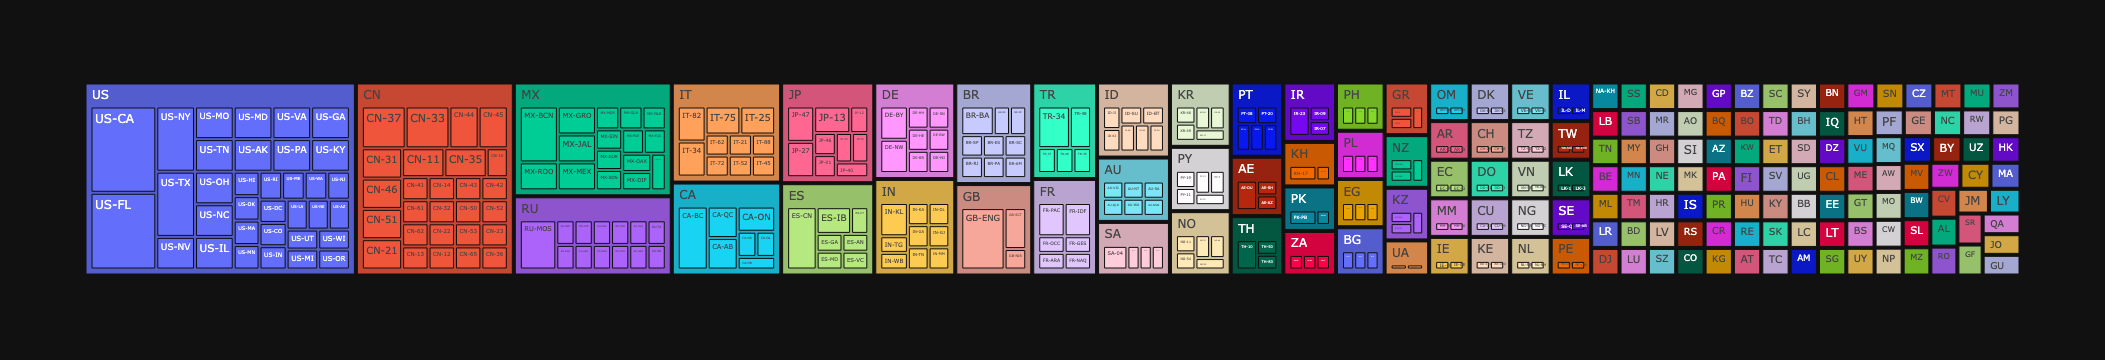

In [12]:
# Install plotly for visualization
!pip install plotly -q
import plotly.express as px

fig = px.treemap(
    df,
    path=["iso_country", "iso_region"],
    values="ct",
    template="plotly_dark",
)
fig.show()

## Summary

Spark session initialized with MinIO S3A support and PyHive utilities ready for Trino demo.
Data distributed across PostgreSQL (customers) and MinIO (orders, products, airports) for realistic federated analytics.

Trino integration enabled with:
- SQL magic for interactive queries
- Federated queries across PostgreSQL and MinIO
- Plotly visualizations for data exploration